In [1]:
!pip install alpha_vantage

import numpy as np
import tensorflow as tf
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

In [2]:
API_key = 'CJCHI2JU6GL00ZW0'

# Get MA5 data
ma5_data, ma5_metadata = TechIndicators(API_key).get_sma(symbol='NVDA', interval='daily', time_period=5, series_type='close')
# Get time history data
ts = TimeSeries(key=API_key, output_format='pandas')
th_data, th_metadata = ts.get_daily(symbol='NVDA', outputsize='compact')

In [3]:
timestamp = list(th_data.index) # Get time stamp for time history
th_data = th_data.to_numpy()

In [ ]:
print(list(ma5_data.values()))
print(timestamp)
print(th_metadata)

In [5]:
# Combine MA5 and time history data
# Columns for the history data: open, high, low, close, volume
# The time history data is only the past 100 days data
ma5_column = []
for i in range(100):
  ma5 = float(list(ma5_data.values())[i]['SMA'])
  ma5_column.append(ma5)

In [6]:
ma5_column = tf.reshape(ma5_column, shape=(100,1))
data = tf.concat((th_data, ma5_column), axis=-1)
print(tf.shape(data))

tf.Tensor([100   6], shape=(2,), dtype=int32)


In [7]:
# Get the dataset for input and output
# Inputs are daily open, high, low, close, volume, and MA5 for the first 5 days
# Outputs are the high, low and close price for the upcoming trading day
a = [0, 1, 2, 3]
dataset = []
raw_dataset = []
for i in range(99,4,-1):
  x = data[i:i-5:-1, :]
  y = data[i-5, :]

  raw_dataset.append([x, y])

  x_mean = tf.math.reduce_mean(x, axis=0)
  x_std = tf.math.reduce_std(x, axis=0)
  # Normalize data
  x = (x - x_mean) / x_std
  y = (y - x_mean) / x_std

  dataset.append([x, y])

In [8]:
# Build the GAN
# Build generator
generator_input = tf.keras.Input(shape=(None, 6))
generator_lstm_1 = tf.keras.layers.LSTM(50)
generator_dense_1 = tf.keras.layers.Dense(50, activation='relu')
generator_dense_2 = tf.keras.layers.Dense(20, activation='relu') # Output of this layer will be as input for the discriminator
generator_dense_3 = tf.keras.layers.Dense(50, activation='relu')
generator_dense_4 = tf.keras.layers.Dense(30, activation='relu')
generator_output_layer = tf.keras.layers.Dense(6)

g_lstm_1_output = generator_lstm_1(generator_input)
g_dense_1_output = generator_dense_1(g_lstm_1_output)
g_dense_2_output = generator_dense_2(g_dense_1_output) # Use this layer as the input for the discriminator
g_dense_3_output = generator_dense_3(g_dense_2_output)
g_dense_4_output = generator_dense_4(g_dense_3_output)
g_output = generator_output_layer(g_dense_4_output)

In [9]:
# Build the discriminator
d_dense_1 = tf.keras.layers.Dense(50, activation='relu')
d_dense_2 = tf.keras.layers.Dense(25, activation='relu')
d_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

d_dense_1_output = d_dense_1(g_dense_2_output)
d_dense_2_output = d_dense_2(d_dense_1_output)
d_output = d_output_layer(d_dense_2_output)

In [10]:
generator = tf.keras.Model(inputs=generator_input, outputs=[g_output ,d_output])
discriminator = tf.keras.Model(inputs=generator_input, outputs=d_output)

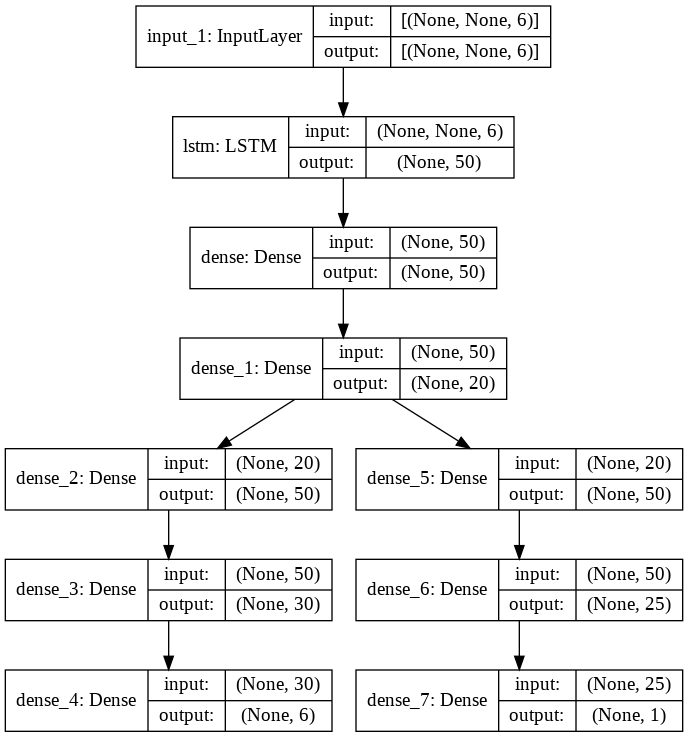

In [11]:
tf.keras.utils.plot_model(generator, show_shapes=True)

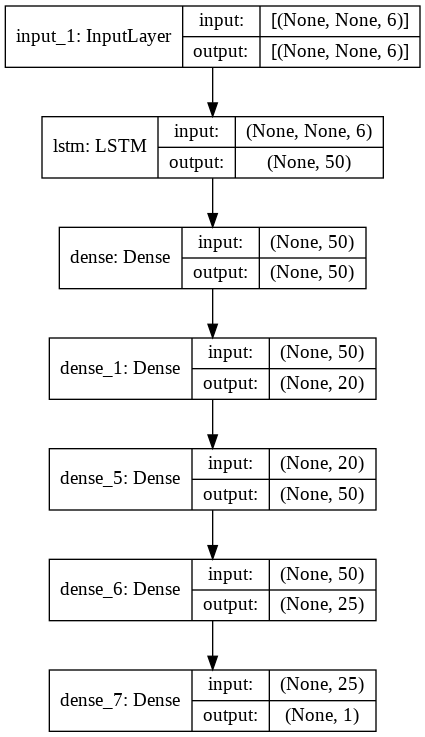

In [12]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [13]:
# Shuffle the dataset
n_train = int(0.7 * len(dataset))
np.random.shuffle(dataset)

# Split data and labels
x_train = []
y_train = []
for i in range(n_train):
  x_train.append(dataset[i][0])
  y_train.append(dataset[i][1])

x_test = []
y_test = []
for i in range(n_train, len(dataset)):
  x_test.append(dataset[i][0])
  y_test.append(dataset[i][1])

In [14]:
# Define the loss of the generator
# The dicriminator label is 0 for fake input, and 1 for real input 
def g_loss(g_y_true, g_y_pred):
  cross_entropy = tf.keras.losses.BinaryCrossentropy()
  mle = tf.keras.losses.MeanSquaredError()
  g_loss = mle(g_y_true[0], g_y_pred[0]) # generator output for regression
  d_loss = cross_entropy(g_y_true[1], g_y_pred[1]) # discriminator output for domain classification

  return g_loss - 0.05 * d_loss

In [ ]:
# Complie discriminator and generator
discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())
g_optimizer = tf.keras.optimizers.Adam(0.01)
# Train the model
epochs = 200
for i in range(epochs):
  print("Current epoch is: "+str(i))
  for j in range(n_train):
    x = x_train[j]
    y_true = y_train[j]
    y_true = tf.reshape(y_true, shape=(1, 6))
    # Train the discriminator
    y_fake = generator(tf.reshape(x, shape=(1, 5, 6)))[0]

    fake_domain_input = tf.concat([x, y_fake], axis=0)
    fake_domain_input = tf.reshape(fake_domain_input, shape=(1, 6, 6))
    real_domain_input = tf.concat([x, y_true], axis=0)
    real_domain_input = tf.reshape(real_domain_input, shape=(1, 6, 6))
    d_input = tf.concat([fake_domain_input, real_domain_input], axis=0)

    fake_domain_true = tf.zeros_like(discriminator(fake_domain_input))
    real_domain_true = tf.ones_like(discriminator(real_domain_input))
    d_true = tf.concat([fake_domain_true, real_domain_true], axis=0)

    # Only train the discriminator, layers connected with generator are not trainable
    generator_lstm_1.trainable = False
    generator_dense_1.trainable = False
    generator_dense_2.trainable = False
    generator_dense_3.trainable = False
    generator_dense_4.trainable = False
    generator_output_layer.trainable = False

    d_dense_1.trainable = True
    d_dense_2.trainable = True
    d_output_layer.trainable = True

    discriminator.fit(x=d_input, y=d_true, batch_size=2, epochs=5, verbose=False) # Train the discriminator 5 times

    # Train the generator
    generator_lstm_1.trainable = True
    generator_dense_1.trainable = True
    generator_dense_2.trainable = True
    generator_dense_3.trainable = True
    generator_dense_4.trainable = True
    generator_output_layer.trainable = True

    d_dense_1.trainable = False
    d_dense_2.trainable = False
    d_output_layer.trainable = False

    with tf.GradientTape() as tape:
      g_y_pred = generator(tf.reshape(x, shape=(1, 5, 6)))
      g_y_true = [y_true, fake_domain_true]
      loss = g_loss(g_y_true, g_y_pred)
    gradient = tape.gradient(loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))

In [16]:
x = x_train[0]
y_fake_g = generator(tf.reshape(x, shape=(1, 5, 6)))[0]
y_fake_d = generator(tf.reshape(x, shape=(1, 5, 6)))[1]

print(y_fake_g)
print(tf.reshape(y_train[0], shape=(1,6)))
print(y_fake_d)

tf.Tensor([[-1.45386    -1.6320399  -1.4454376  -1.3773918   0.23251842 -1.3870178 ]], shape=(1, 6), dtype=float32)
tf.Tensor([[-2.4432855 -2.2776885 -1.3195785 -1.0846807 -1.648416  -4.1295085]], shape=(1, 6), dtype=float32)
tf.Tensor([[0.9449097]], shape=(1, 1), dtype=float32)


In [17]:
# Check the test data
n_test = tf.shape(x_test)[0]
test_loss = 0
for i in range(n_test):
  x = x_test[i]
  x = tf.reshape(x, shape=(1, 5, 6))
  y = y_test[i]
  y = tf.reshape(y, shape=(1, 6))

  y_pred = generator(x)[0]
  test_loss += tf.keras.losses.mean_squared_error(y_true=y, y_pred=y_pred)

print(test_loss / float(n_test))

tf.Tensor([4.720868], shape=(1,), dtype=float32)


In [25]:
# Compare the real values and predicted values
n_data = len(raw_dataset)

close_price_real = []
close_price_pred = []

high_price_real = []
high_price_pred = []

low_price_real = []
low_price_pred = []

for i in range(n_data):
  x_raw = raw_dataset[i][0]
  y_raw = raw_dataset[i][1]

  high_price_real.append(y_raw[1])
  low_price_real.append(y_raw[2])
  close_price_real.append(y_raw[3])

  x_raw_mean = tf.math.reduce_mean(x_raw, axis=0)
  x_raw_std = tf.math.reduce_std(x_raw, axis=0)

  x = (x_raw - x_raw_mean) / x_raw_std
  x = tf.reshape(x, shape=(1, 5, 6))

  y_pred = generator(x)[0]

  high_price_pred.append(y_pred[0, 1] * x_raw_std[1] + x_raw_mean[1])
  low_price_pred.append(y_pred[0, 2] * x_raw_std[2] + x_raw_mean[2])
  close_price_pred.append(y_pred[0, 3] * x_raw_std[3] + x_raw_mean[3])

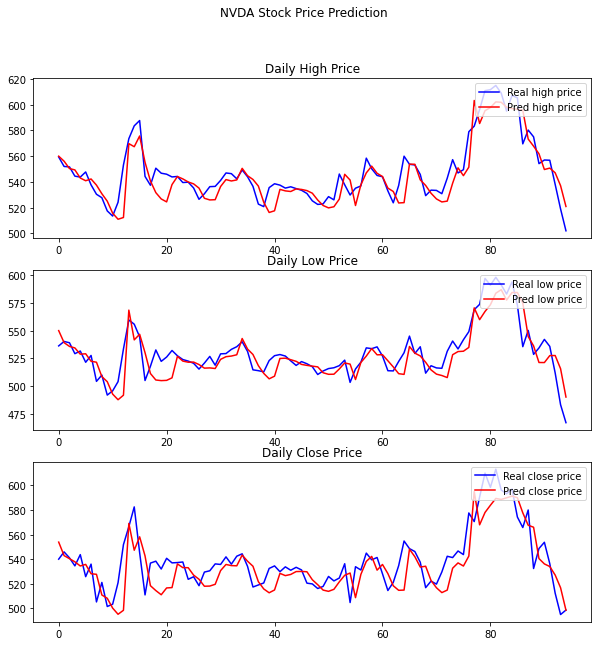

In [30]:
import matplotlib.pyplot as plt
time_x = range(len(high_price_pred))
fig, ax = plt.subplots(3, figsize=(10, 10))

fig.suptitle('NVDA Stock Price Prediction')
ax[0].set_title('Daily High Price')
ax[1].set_title('Daily Low Price')
ax[2].set_title('Daily Close Price')

# Draw the high price prediction
ax[0].plot(time_x, high_price_real, color='blue', label='Real high price')
ax[0].plot(time_x, high_price_pred, color='red', label='Pred high price')
ax[0].legend(loc="upper right")

# Draw the low price prediction
ax[1].plot(time_x, low_price_real, color='blue', label='Real low price')
ax[1].plot(time_x, low_price_pred, color='red', label='Pred low price')
ax[1].legend(loc="upper right")

# Draw the close price prediction
ax[2].plot(time_x, close_price_real, color='blue', label='Real close price')
ax[2].plot(time_x, close_price_pred, color='red', label='Pred close price')
ax[2].legend(loc="upper right")